In [31]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [32]:
import os
import sys

try:
    import google.colab  # Check if running in Google Colab
    IN_COLAB = True

except ImportError:
    IN_COLAB = False

if IN_COLAB:
    repo_name = 'conn4-rl'
    %cd /content
    if os.path.exists(repo_name):
        %cd {repo_name}
        !git pull  # Pull the latest changes
    else:
        !git clone https://github.com/Wikcio1618/conn4-rl.git
        %cd {repo_name}
    sys.path.append('/content/my_project')
else:
    # Local execution
    print("Running locally, not in Colab.")

Running locally, not in Colab.


# Hyper Parameters

In [33]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.1
eps_decay = 0.999997
buffer_size = 10**4
epochs = 10**2
batch_size = 64
train_freq = 1
target_update_freq = 300
eval_freq = 10
checkpoint_freq = epochs // 10
gamma = 0.98
lr = 1e-5

remove_random_time = epochs // 2

# Initialize Models

In [34]:
from typing import List
from agents.agent import Agent
from agents.learning_agent import LearningAgent
from agents.random_agent import RandomAgent
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

num_learning_agents = 3

main_models: List[Agent] = [ConnectFourNN().to(device) for _ in range(num_learning_agents)]

target_models: List[Agent] = [ConnectFourNN().to(device) for _ in range(num_learning_agents)]
for i, model in enumerate(target_models):
    model.eval()
    model.load_state_dict(main_models[i].state_dict())

replay_buffers:List[ReplayBuffer] = [ReplayBuffer() for _ in range(num_learning_agents)]

optimizers: List = [optim.Adam(main_models[i].parameters(), lr=lr) for i in range(num_learning_agents)]

agents = [LearningAgent(main_models[i], target_models[i], replay_buffers[i], optimizers[i], eps=eps, device=device) for i in range(num_learning_agents)]
# agents.append(RandomAgent())

# Training Loop

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:07<01:13,  1.24it/s]

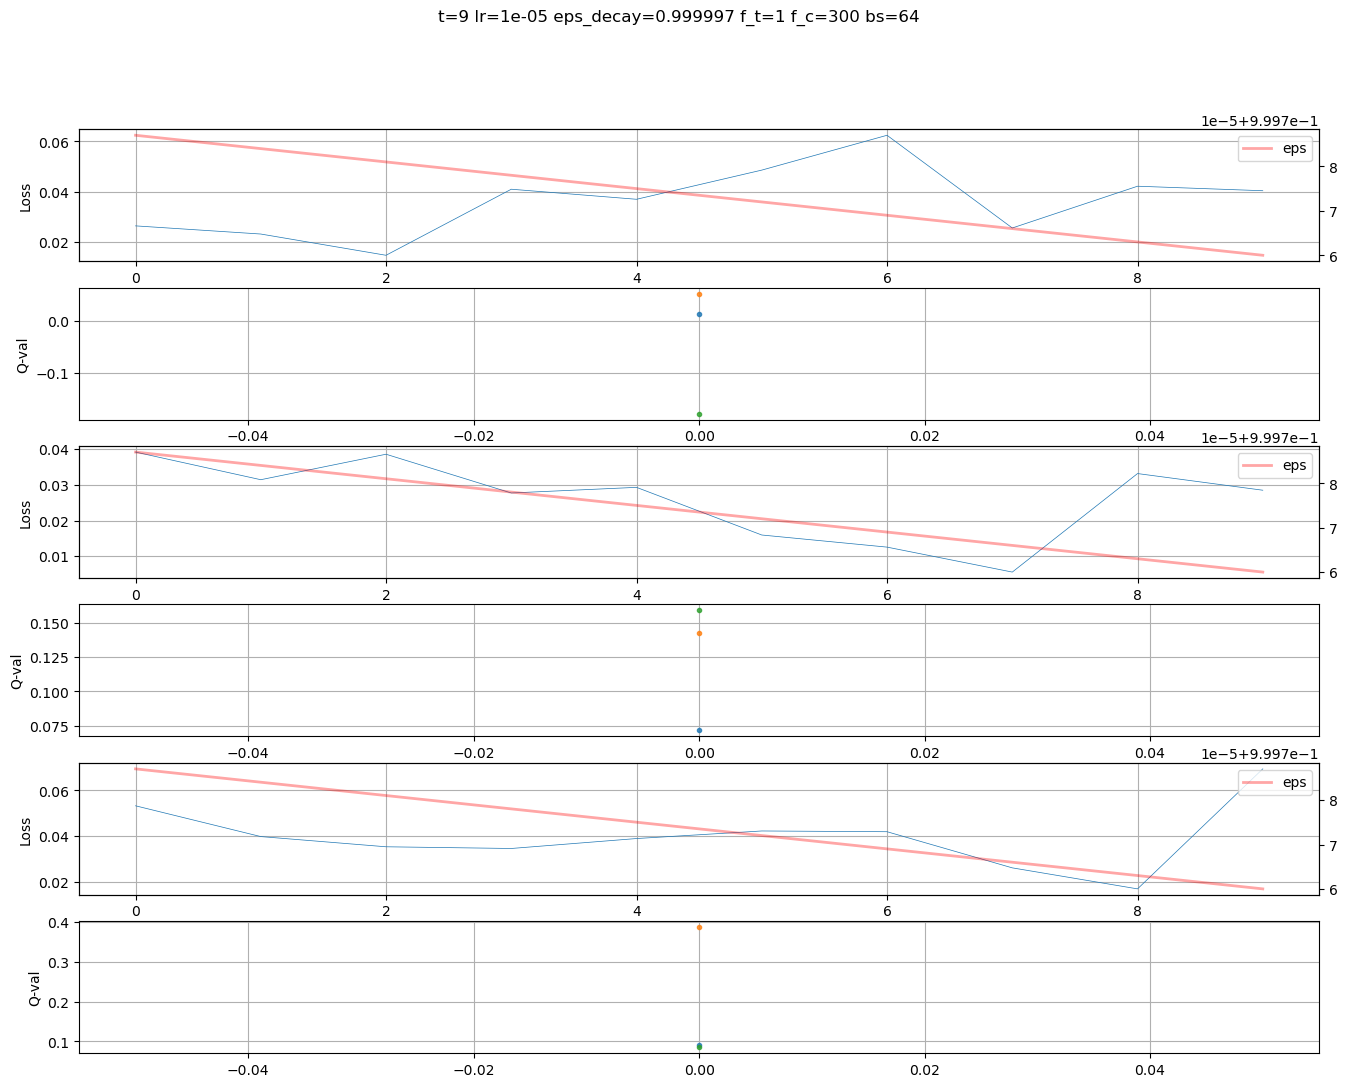

 19%|█▉        | 19/100 [00:16<00:56,  1.43it/s]

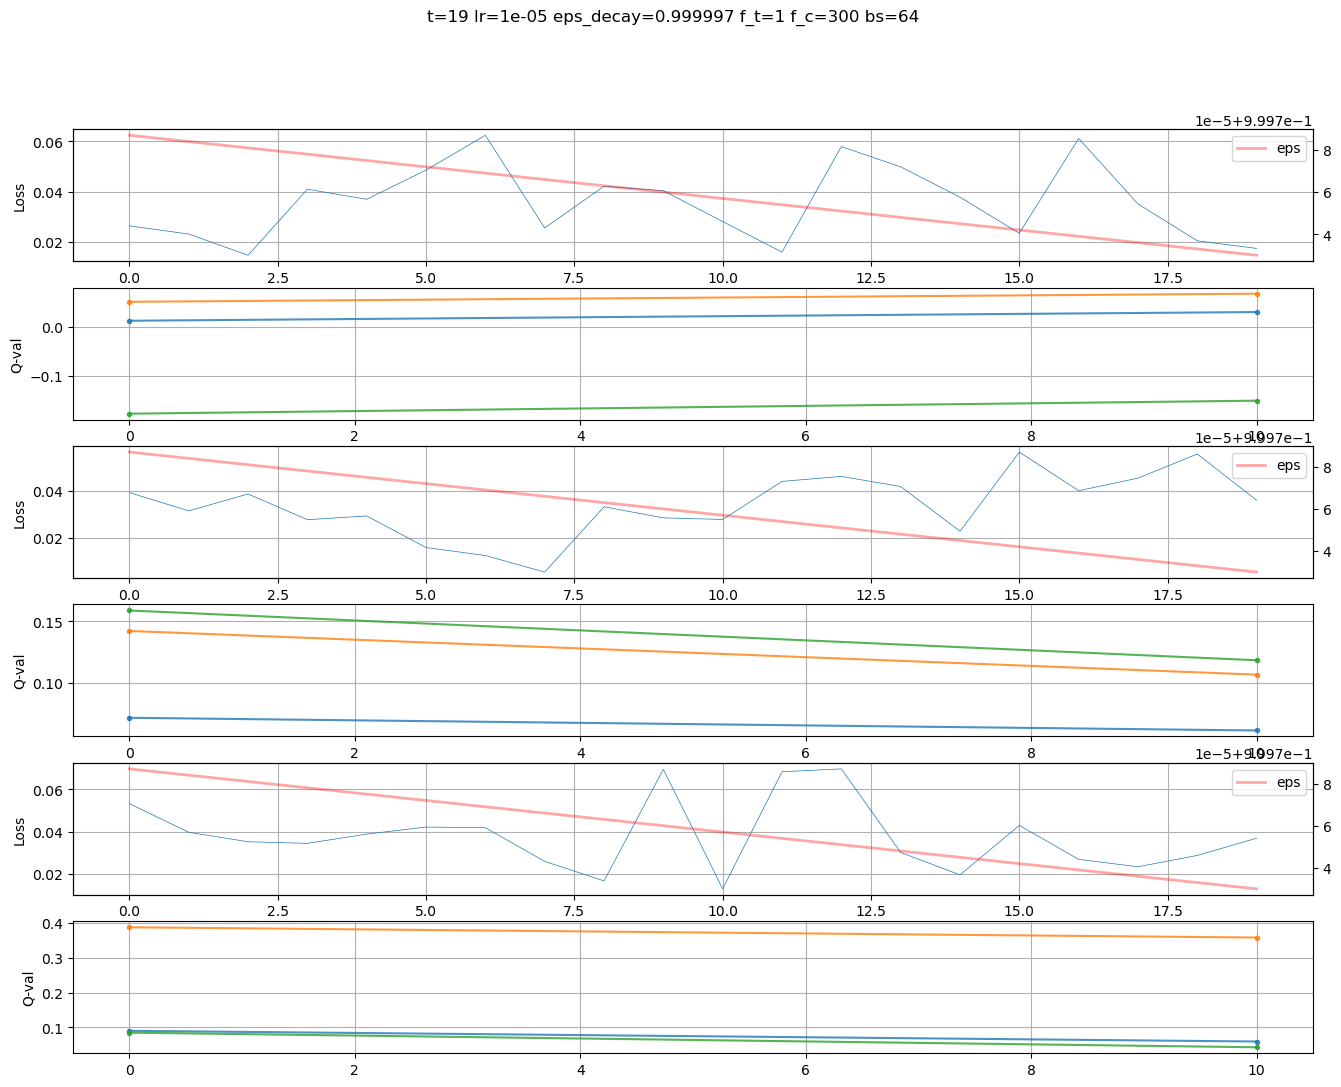

 29%|██▉       | 29/100 [00:27<01:00,  1.18it/s]

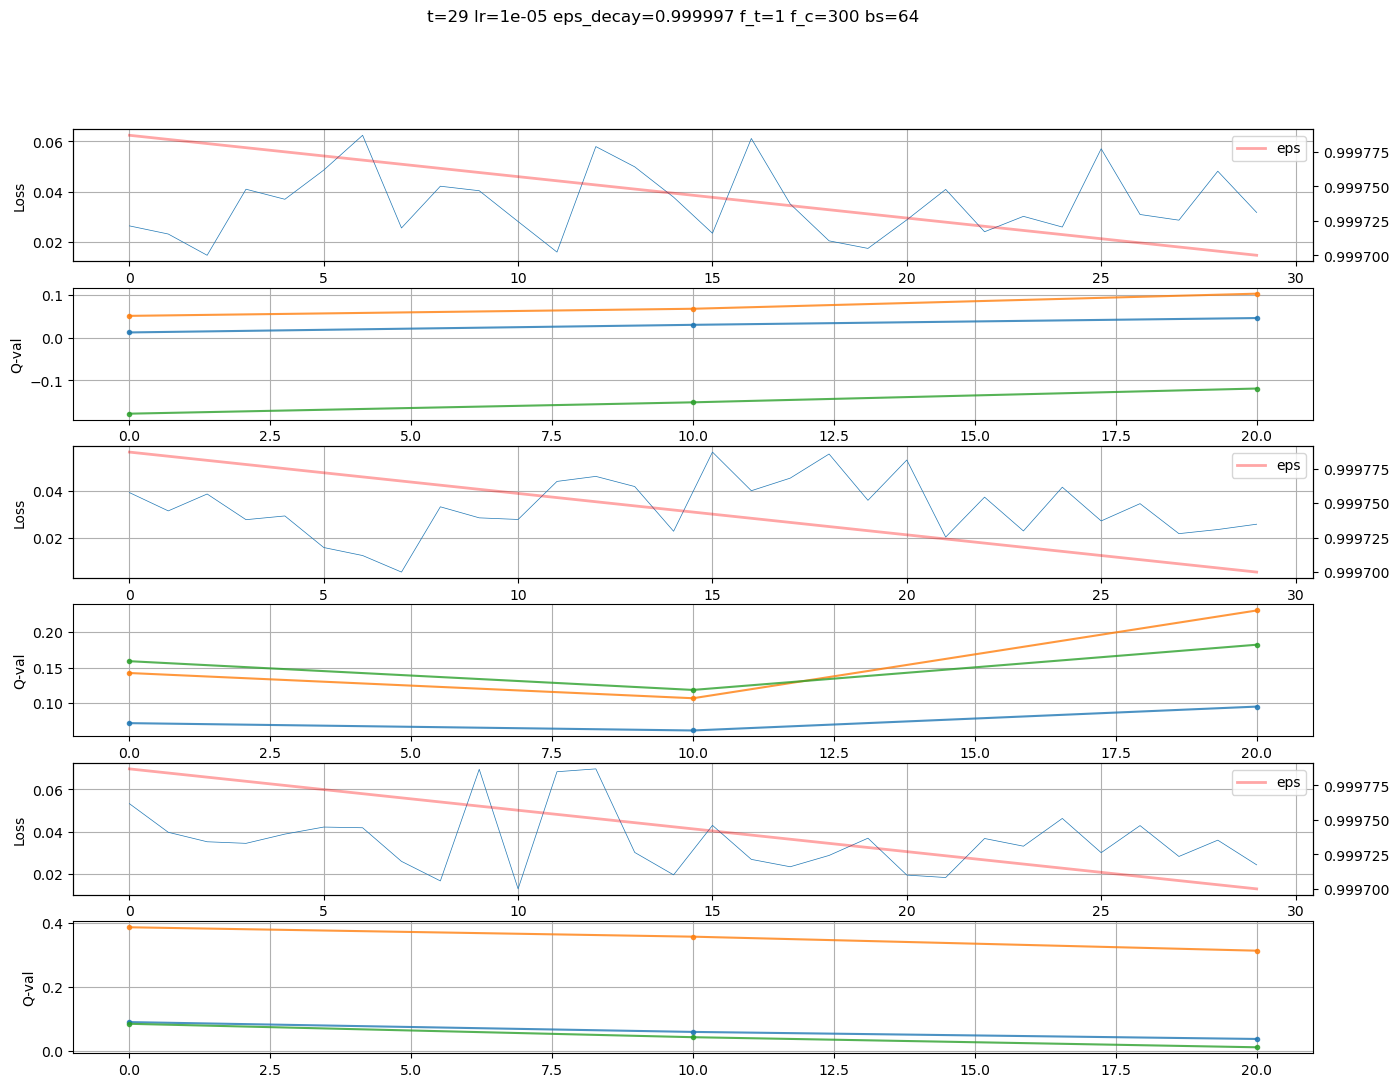

 39%|███▉      | 39/100 [00:40<01:12,  1.18s/it]

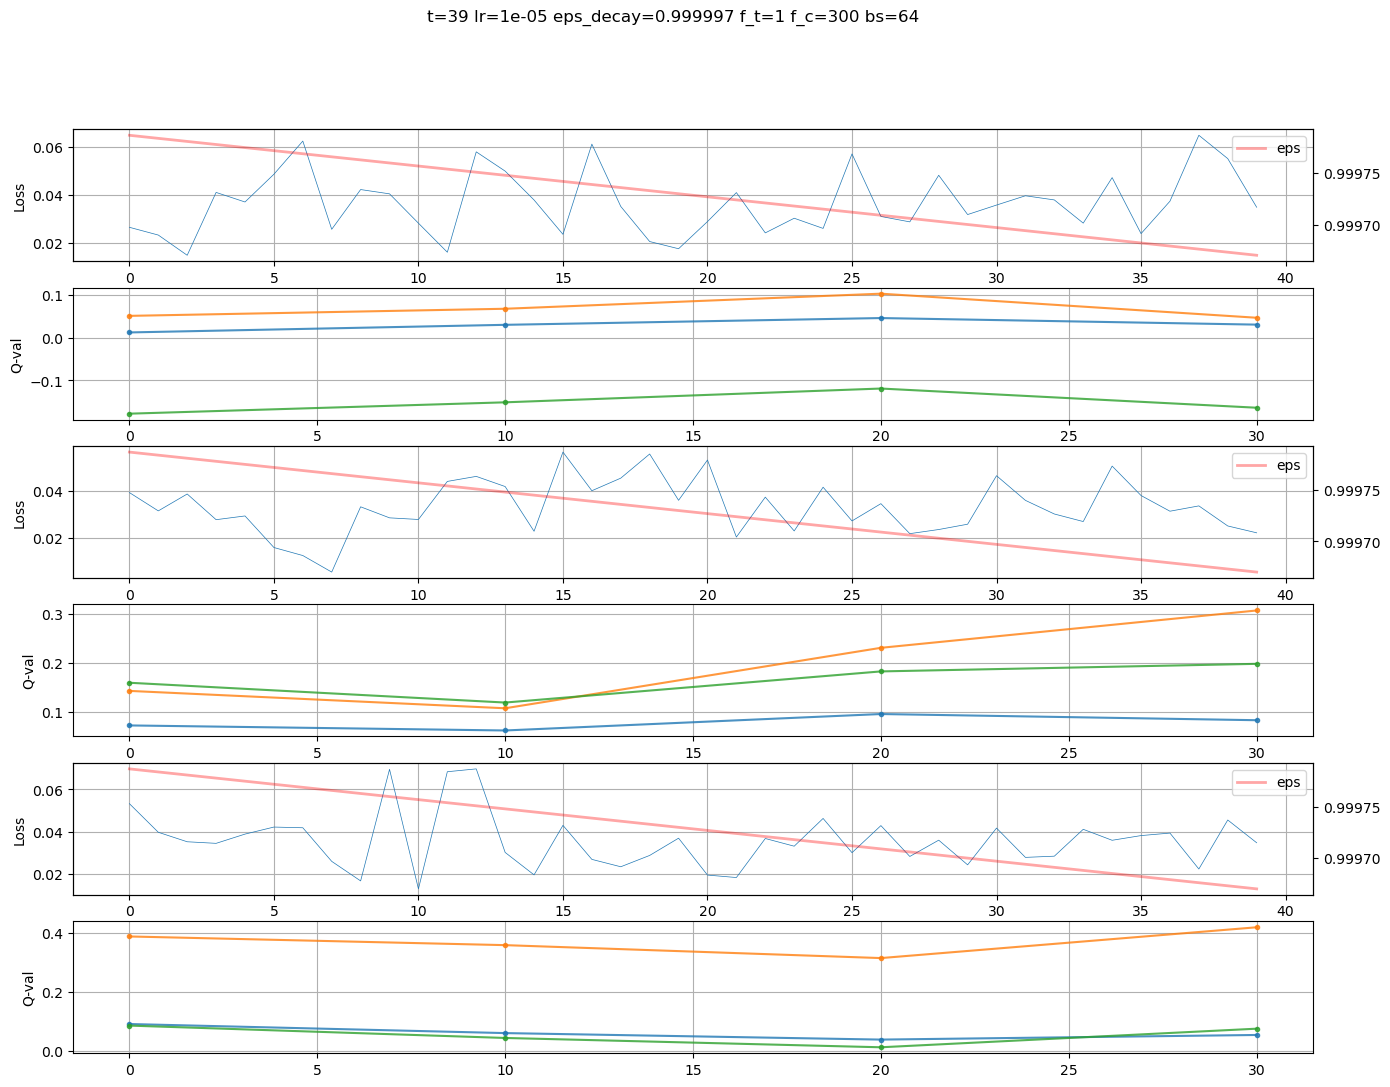

 49%|████▉     | 49/100 [00:52<00:45,  1.12it/s]

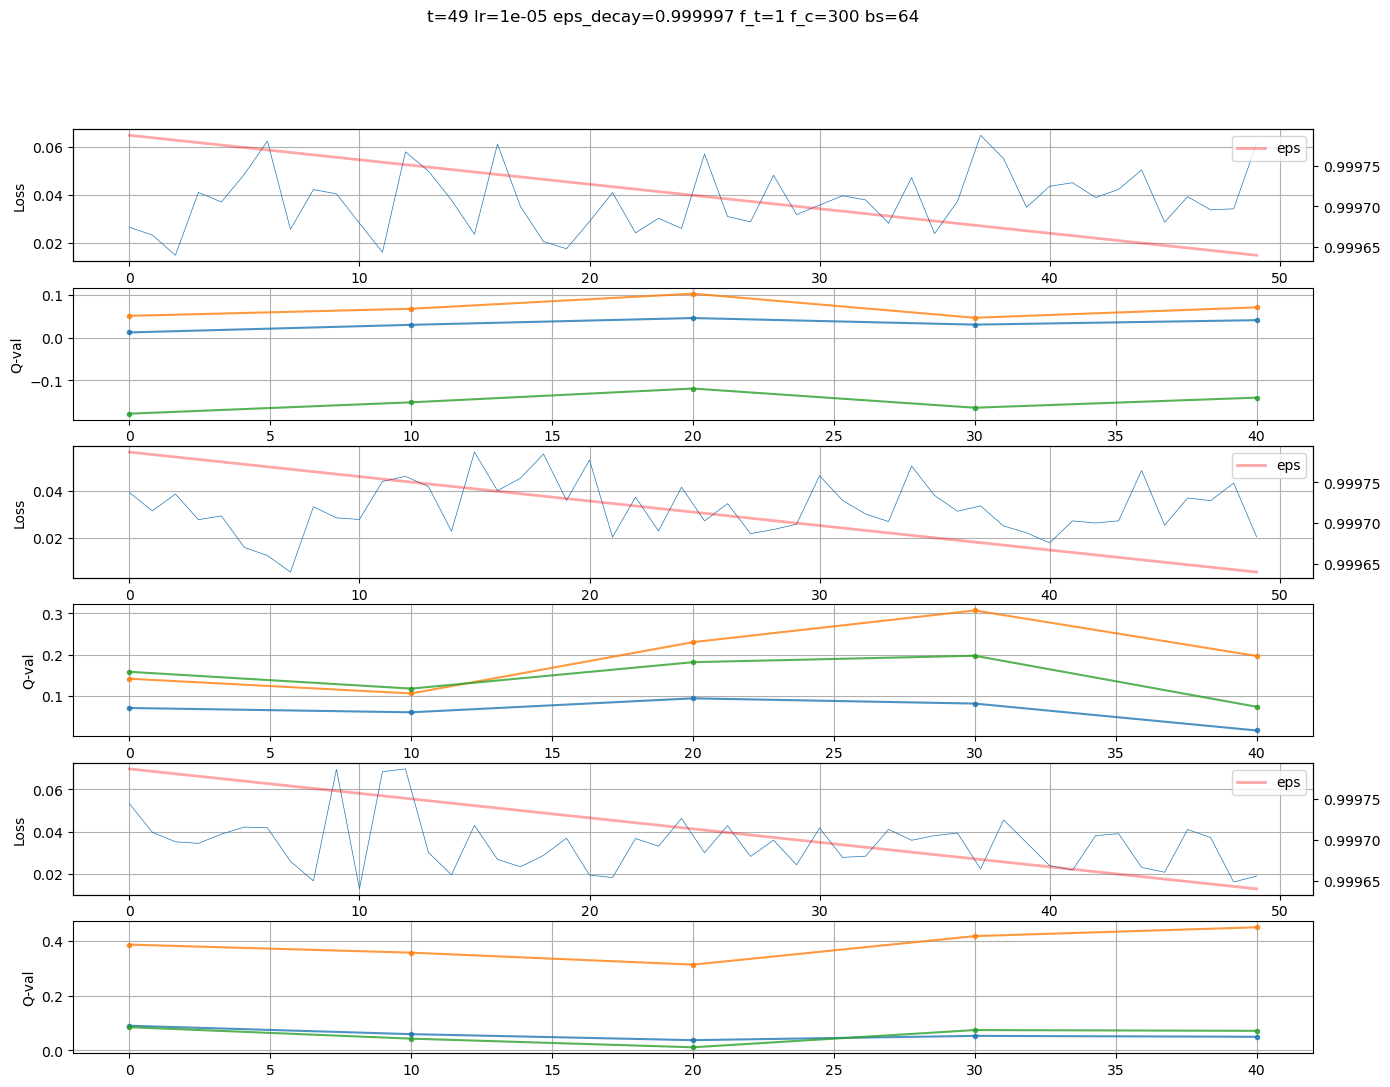

 56%|█████▌    | 56/100 [01:01<00:48,  1.11s/it]


KeyboardInterrupt: 

In [37]:
from datetime import datetime
import itertools
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from game import Game

losses = [[] for _ in range(num_learning_agents)]
times = []
EPS = []
results = []
eval_times = []
eval_scores1 = [], []
qvals = [[[] for _ in range(3)] for _ in range(num_learning_agents)]

for t in tqdm(range(epochs)):
    for pair in itertools.combinations(agents, 2):
        # makes sure players play on both sides
        pair = list(pair)
        random.shuffle(pair)
        Game.play_exp_game(pair)

    if not (t+1) % train_freq:
        times.append(t)
        EPS.append(eps)
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):
                loss = agent.train_step(batch_size, gamma)
                losses[i].append(loss)

    if not (t+1) % target_update_freq:
        for agent in agents:
            if isinstance(agent, LearningAgent):
                agent.update_target_model()

    if not t % eval_freq:
        eval_times.append(t)
        # eval_scores1.append(play_eval_game(agent1, num_games=20))
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):
                q_vals = agent.get_action_qval()
                for j, q in enumerate(q_vals):
                    qvals[i][j].append(q_vals[j])

    # if t == remove_random_time:
    #     for i, agent in enumerate(agents):
    #         if not isinstance(agent, LearningAgent):
    #             del agents[i]

    if not (t+1) % checkpoint_freq:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):   
                path = rf'logs/cp{(t+1)//checkpoint_freq}_agent{i}_{stamp}.pth'     
                torch.save(main_models[i], path)

        plt.figure(figsize=(10, 16))
        plt.suptitle(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')

        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):
                plt.subplot(num_learning_agents * 2, 1, 1+i*2)  
                plt.plot(times, losses[i], linewidth=0.5)
                plt.ylabel("Loss")
                plt.grid()
                ax2 = plt.twinx()
                ax2.plot(times, EPS, 'r-', label='eps', linewidth=2, alpha = 0.35)
                ax2.legend()

                plt.subplot(num_learning_agents*2, 1, i*2+2)
                for j in range(len(q_vals)):
                    plt.plot(eval_times, qvals[i][j], 'o-', markersize=3, alpha=0.8)
                plt.ylabel('Q-val')
                plt.grid()
        
        plt.show()

    if eps > eps_min:
        eps *= eps_decay